# PHYSLITE Jets

A nice thing about PHYSLITE the data is written with corrections - so even when you access them with `EventLoop` it can be done very fast (applying corrections is amazingly expensive).

## Using the ServiceX Backend

In [ ]:
from servicex import ignore_cache
from func_adl_servicex_xaodr22 import calib_tools, SXDSAtlasxAODR22

In [ ]:
ds = SXDSAtlasxAODR22('mc23_13p6TeV.601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad.deriv.DAOD_PHYSLITE.e8514_e8528_s4159_s4114_r14799_r14811_p5855?files=1', backend="atlasr22")
ds = calib_tools.query_update(
    ds, calib_config=calib_tools.default_config("PHYSLITE")
)

In [ ]:
good_jets = ds.Select(
    lambda e: {
        "run": e.EventInfo("EventInfo").runNumber(),
        "event": e.EventInfo("EventInfo").eventNumber(),
        "good_jets": e.Jets()
                     .Where(lambda j: (j.pt() / 1000 > 25.0) and (abs(j.eta()) < 2.5)),
    }
)

In [ ]:
jet_pt = good_jets.Select(lambda e: {
    "run": e.run,
    "event": e.event,
    "pt": e.good_jets.Select(lambda ele: ele.pt() / 1000.0),
})

In [ ]:
jet_dask_data = jet_pt.value()

## Using a local Run

A few things:

* `docker` must be installed locally
* `docker` must be running! You'll get a very odd error from `docker` that isn't indicative that it isn't running if it isn't. And this error won't happen until you actually try to `value()` your expression.

This file was made local using the following `rucio`:

```python

```


In [1]:
from func_adl_servicex import SXLocalxAOD
from func_adl_servicex_xaodr22.event_collection import Event
from func_adl_servicex_xaodr22 import atlas_release, calib_tools
print (atlas_release)

from pathlib import Path
import awkward as ak
import matplotlib.pyplot as plt

22.2.113


In [2]:
class xAODLocalTyped(SXLocalxAOD[Event]):
    def __init__(self, file_path: Path):
        super().__init__(
            file_path,
            item_type=Event,
            docker_image="gitlab-registry.cern.ch/atlas/athena/analysisbase",
            docker_tag=atlas_release,
        )


In [3]:
dataset_path = Path(r"C:\Users\gordo\Code\atlas\data\R24\601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad_PHYSLITE\DAOD_PHYSLITE.35040212._000001.pool.root.1")
assert dataset_path.exists()

With that hand-coded infrastructure out of the way, we can now operate on the local file as if it was a normal SX dataset.

* Ignore the backend warnings with the next line - there really isn't a backend involved for the local running.

In [4]:
ds = xAODLocalTyped(dataset_path)
ds = calib_tools.query_update(
    ds, calib_config=calib_tools.default_config("PHYSLITE")
)

Found backend type matching "xaod". Matching by type is deprecated. Please switch to using the "name" keyword in your servicex.yaml file.
Found backend type matching "xaod". Matching by type is deprecated. Please switch to using the "name" keyword in your servicex.yaml file.


In [5]:
good_jets = ds.Select(
    lambda e: {
        "run": e.EventInfo("EventInfo").runNumber(),
        "event": e.EventInfo("EventInfo").eventNumber(),
        "good_jets": e.Jets()
                     .Where(lambda j: (j.pt() / 1000 > 25.0) and (abs(j.eta()) < 2.5)),
    }
)

In [10]:
jet_pt = good_jets.Select(lambda e: {
    "run": e.run,
    "event": e.event,
    "pt": e.good_jets.Select(lambda ele: ele.pt() / 1000.0),
}).AsAwkwardArray()

In [14]:
jet_data_dask = jet_pt.value()

In [15]:
jet_data_dask.pt.compute()

<Array [[67.6, 61.3, 52.3, 32.2], ..., [...]] type='10000 * var * float64'>

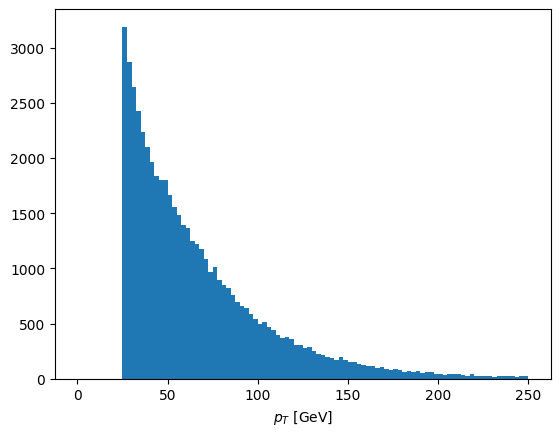

In [16]:
plt.hist(ak.flatten(jet_data_dask.pt).compute(), bins=100, range=(0, 250))
plt.xlabel("$p_T$ [GeV]")
plt.show()

In [17]:
jets_count = ak.count(jet_data_dask.pt, axis=-1).compute()

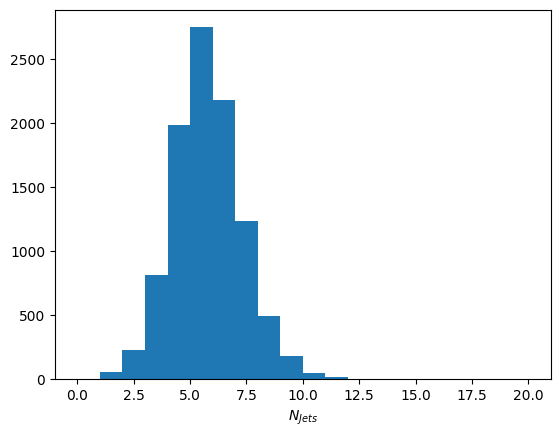

In [18]:
plt.hist(jets_count, bins=20, range=(0, 20))
plt.xlabel("$N_{Jets}$")
plt.show()